# Introduction

While starvation has almost disappeared in most developed countries, people are nowadays more likely to die from overeating than from a lack of food. We eat badly and it's a serious public health problem in our modern societies. Even if taking the healthiness aspect in food recommendation systems won't entirely solve the problem, it can help people without special knowledge to eat the right food. These recommendations should take into account the user's tastes and give further information about the nutritive aspect of the recipes.

The 21st century represents one of the most progressive eras in human history. We are busier than ever. We live fast and we eat fast. Our goal is to create a recipe recommendation system that would allow users to enjoy generated meals according to their preferences, physical activity and taste while allowing them to see information about the healthiness of their choices.

To show the approximated healthiness of the recommended recipes, we  we have considered the proposed nutritional requirements recommended by [FDA](https://www.fda.gov/AboutFDA/Transparency/Basics/ucm194877.htm). Based on this, a healthy menu for an adult person consists of meals that fill the $2000$ kcal daily goal.

The last part of our project takes into consideration that cooking is not only about aiming to fulfill some proposed values in order to be healthy. Beside that, it is usually fun. By answering the question about cuisine and ingredients similarities, we offer our user to explore the world of food in a way which will hopefully make it more interesting to follow a certain healthy diet.

In [3]:
import requests
import os
import sys
import pandas as pd
import numpy as np
import json
import re
import shutil
from tqdm import tqdm
import glob
import csv
import matplotlib as plt
import pprint
%matplotlib inline
import warnings
import folium
warnings.filterwarnings("ignore")

# Example data

Our first dataset on recipes comes from http://lherranz.org/datasets/ and containes 27638 json files that we explored.

# Scraping data

We have used the 'url' json attribute of each recipe and on that page we have found the reviews for that recipe. Using the requests, we managed to collect all elements needed so that we could obtain data on users and ratings they left for that specific recipe. This was collected in a json format, which we later converted to csv.

In [ ]:
recipe_file = open('reviews.json', 'a')
users_ratings = {}
counter = 0
for file in os.listdir(directory):
    filename = os.fsdecode(os.path.join(directory, file))
    counter+=1
    try:
        with open(filename) as json_data:
            d = json.load(json_data)
            URL = d['attribution']['url']
            recipe_id = d['id']
            r = requests.get(URL)
            soup = BeautifulSoup(r.content, 'html.parser')
            elements = soup.find_all(class_="review")
            for el in elements[1:]:
                try:       
                    user_url ='https://www.yummly.com' + str(el.select(".review-name a")[0].attrs["href"])
                    user = user_url[user_url.rfind('/')+1:]
                    rating = len(el.select(".review-rating .full-star")) + 0.5 * len(el.select(".review-rating .half-star"))
                    recipe_file.write('{{"user":"{}", "recipe_id":"{}", "rating":{},"user_url":"{}"}},\n'.format(user,recipe_id,rating,user_url))
                    
                except AttributeError as err:
                    user = 'np.nan'
                    user_url = 'np.nan'
                    rating = 'np.nan'
                    review = 'np.nan'
        print(filename)
        shutil.move(filename, done)
    except:
        print(str.format("Error occured: {}",sys.exc_info()))
        invalid_json_files.write(filename+'/n')



Since our initial data was sparse, we needed more data to build a valid recommendation system. With our previous scraping, we obtained user urls which allowed us to perform another scraping, but now aiming for the recipes they have saved on their account under saved recipes. This is a collection of all the recipes they would like to try, make or have alredy explored, which is why it presents a great source of information for building a recommendation system.

In [ ]:
user_saved_recipes_file = open('user_saved_recipes_file.json', 'a')
with open(directory+"users_rest.csv", 'r') as data_file:
    reader = csv.reader(data_file, delimiter='\t')
    for index, (user_url) in tqdm(enumerate(reader)):
        try:
            r = requests.get(user_url[0])
            soup = BeautifulSoup(r.content, 'html.parser')
            element = soup.find(class_="content")
            all_yums = str(element.find('a')['href'])
            r = requests.get(user_url[0]+'/collections/all-yums')
            soup = BeautifulSoup(r.content, 'html.parser')
            elements = soup.select(".recipe-card.single-recipe")
            for el in elements:
                recipe_id = el.attrs["data-url"]
                user_saved_recipes_file.write('{{"user":"{}", "recipe_id":"{}"}},\n'.format(user_url[0][user_url[0].rfind('/')+1:],recipe_id))


        except Exception as error:
            print(str(error))

Now some of these new recipes observed were new in our dataset, hence we didn't have more information about them except the recipe id. However, yummly.com provides an api especially for academic use, for which we have obtained developer key and the scraping of these additional recipes was not a problem. We gathered more json data, so we procceeded reading it as before. 

# Reading data

After our dataset has been collected by scraping the yummly website, we have obtained multiple json files on recipes. By analyzing the data, we have observed that each json file provides wide range of information we could use, but we need to restrict our selection to data that would be essential for this project. So when building the csv with only relevant information on recipes we have extracted types of course, cuisine, time and list of ingredients for each recipe, as the needed information for our analysis. This has been saved into csv files which are used for the rest of the project. Even though there are several attributes describing preparation time of recipe we have chosen the one given in seconds, because it's the most consistent in the dataset, unlike the other values that could sometime be in minutes and sometimes hours and minutes, and so on. 
    
For extracting information on nutritional values for recipes, we have used flatten_json because the data on nutrients comes in a shape of a dictionary of dictionaries as each unit has its own additional values.

In [5]:
recipes = pd.read_csv('recipes.csv', index_col='recipe_id')


In [6]:
recipes.shape

(33872, 5)

In [7]:
recipes.index.is_unique

True

# Food healthiness investigation

As lifestyle-illness like diabetes and obesity reach more and more people, especially in the USA, it seemed essential to take the healthiness of the recipes into account in our recommendations. This epidemic reduces life expectancy and costs a lot to health care systems but is actually pretty easy to stop : it's all about learning how to eat properly. 

The goal was to get an user-friendly way to evaluate how healthy some food is and visualize it in a way such that anyone can understand it without having advanced notions of nutrition. There are several ways to measure the healthiness of a recipe and none of them is perfect. A first step can be to compare the quantity of different nutrients to the daily value references (DVR). However, raw percentages are usually hard to interpret for inexperienced people and values corresponding to little known nutrients like selenium is pretty irrelevant to the consumer.

That's why the traffic light rating system was implemented instead. It consists in assigning a score to each of the attributes \textbf{total fat}, \textbf{saturated fatty acids}, \textbf{sugar} and \textbf{sodium} (salt) which are the main nutrients and indicators of the healthiness of the food. The range of the scores is 1 (good) to 3 (bad) and they are then summed to get a global score for the whole recipe. However, since the recipes contain different quantity of food, it's unfair to compare the raw values of these nutrients ; instead, they are normalized according to the weight of the recipe.

The scores obtained are thus between 4 and 12, the range 4-6 indicating that the food is quite healthy, the range 7-9 being average, and the range 10-12 corresponding to pretty unhealthy recipes (to consume with moderation).

This notebook retraces all the steps of the healthiness investigation we made, from the data cleaning to the traffic light plots.

In [1]:
import pandas as pd
import numpy as np

# Nutrition visualization

## Our data about nutrition

The **nutrition.csv** file contains informations about the nutrients of each recipe. It can be used to determine how healthy some food is and to recommend the right recipe to an user who wants to eat healthy meals for example. However, most people don't know how to read that kind of informations, don't know how many grams of proteins they should eat everyday, and can't see the difference between bad fats and good fats. That's why we want an easy way to visualize the quantity of nutrients compared to the daily value references and how healthy a recipe is. The raw file **nutrition.csv** is somewhat messy and we will have to clean it a little bit.

In [2]:
nutrition = pd.read_csv('full_nutrition.csv', index_col=['recipe_id','attribute'], usecols=['recipe_id', 'attribute','description','unit_abbreviation','unit_decimal','unit_name','unit_plural','unit_pluralAbbreviation',  'value'])
print('The columns are : ' + str(nutrition.columns))
nutrition.head()

The columns are : Index(['description', 'unit_abbreviation', 'unit_decimal', 'unit_name',
       'unit_plural', 'unit_pluralAbbreviation', 'value'],
      dtype='object')


description unit_abbreviation  \
recipe_id                   attribute                                   
--Naan_-Boiled-rice-1362073 FAT_KCAL            NaN              kcal   
                            K          Potassium, K                 g   
                            FLD         Fluoride, F                 g   
                            PHYSTR     Phytosterols                 g   
                            VAL_G            Valine                 g   

                                       unit_decimal unit_name unit_plural  \
recipe_id                   attribute                                       
--Naan_-Boiled-rice-1362073 FAT_KCAL           True   calorie    calories   
                            K                  True      gram       grams   
                            FLD                True      gram       grams   
                            PHYSTR             True      gram       grams   
                            VAL_G              True      gram       grams   

                                      unit_pluralAbbreviation   value  
recipe_id                   attribute                                  
--Naan_-Boiled-rice-1362073 FAT_KCAL                     kcal  250.00  
                            K                           grams    1.51  
                            FLD                         grams    0.00  
                            PHYSTR                      grams    0.02  
                            VAL_G                       grams    0.21

We have several columns showing the nutritional informations we need about the recipes. The indexing is not unique because when doing the scrapping, some recipes were added twice to the data set : we just drop the duplicates from the data frame to make it unique.

In [3]:
print('Is the index unique : ' + str(nutrition.index.is_unique))

Is the index unique : True


In [4]:
nutrition = nutrition[~nutrition.index.duplicated(keep='first')]
print('Is the new index unique : ' + str(nutrition.index.is_unique))

Is the new index unique : True


In [5]:
nutrition.reset_index(inplace=True)

We can check that the attribute corresponding to the description 'Sodium Na' is **NaN** so we replace it with a proper value. It is the only one missing in the data frame (as well as the descriptions for the fat calories but they are not really important for now).

In [6]:
nutrition.loc[nutrition['attribute'].isnull(), ['attribute']] = 'SOD'

There are two attributes for the total energy, one in **KJ** and the other one in **KCAL**. To distinguish them, we precise the unit is in **KJ** for the attribute **ENERC_KJ**.

In [7]:
nutrition.loc[nutrition['attribute'] == 'ENERC_KJ', ['description']] = 'Energy, KJ'

Let's use the recipe_id and the attributes as index :

In [8]:
nutrition.set_index(['recipe_id', 'attribute'], drop=True, inplace=True)
nutrition.head()

description unit_abbreviation  \
recipe_id                   attribute                                   
--Naan_-Boiled-rice-1362073 FAT_KCAL            NaN              kcal   
                            K          Potassium, K                 g   
                            FLD         Fluoride, F                 g   
                            PHYSTR     Phytosterols                 g   
                            VAL_G            Valine                 g   

                                       unit_decimal unit_name unit_plural  \
recipe_id                   attribute                                       
--Naan_-Boiled-rice-1362073 FAT_KCAL           True   calorie    calories   
                            K                  True      gram       grams   
                            FLD                True      gram       grams   
                            PHYSTR             True      gram       grams   
                            VAL_G              True      gram       grams   

                                      unit_pluralAbbreviation   value  
recipe_id                   attribute                                  
--Naan_-Boiled-rice-1362073 FAT_KCAL                     kcal  250.00  
                            K                           grams    1.51  
                            FLD                         grams    0.00  
                            PHYSTR                      grams    0.02  
                            VAL_G                       grams    0.21

## Daily Value reference of the Dietary

The daily value references are based on a 2,000 calories diet and can be adapted proportionally to any people. We are using here the values for adult people (and non-pregnant women). These values can be found here : https://www.dsld.nlm.nih.gov/dsld/dailyvalue.jsp.

In [9]:
nutrients = ['Total fat', 'Saturated fatty acids', 'Cholesterol', 'Sodium', 'Potassium', 'Total carbohydrate', 'Fiber', 'Protein', 'Vitamin A', 'Vitamin C', 'Calcium', 'Iron', 'Vitamin D', 'Vitamin E', 'Vitamin K', 'Thiamin', 'Riboflavin', 'Niacin', 'Vitamin B6', 'Folate', 'Vitamin B12', 'Biotin', 'Pantothenic acid', 'Phosphorus', 'Iodine', 'Magnesium', 'Zinc', 'Selenium', 'Copper', 'Manganese', 'Energy', 'Sugar']
units = ['grams (g)', 'grams (g)', 'milligrams (mg)', 'milligrams (mg)', 'milligrams (mg)', 'grams (g)', 'grams (g)', 'grams (g)', 'International Unit (IU)', 'milligrams (mg)', 'milligrams (mg)', 'milligrams (mg)', 'International Unit (IU)', 'International Unit (IU)', 'micrograms (µg)', 'milligrams (mg)', 'milligrams (mg)', 'milligrams (mg)', 'milligrams (mg)', 'micrograms (µg)', 'micrograms (µg)', 'micrograms (µg)', 'milligrams (mg)', 'milligrams (mg)', 'micrograms (µg)', 'milligrams (mg)', 'milligrams (mg)', 'micrograms (µg)', 'milligrams (mg)', 'milligrams (mg)', 'kilocalories (kcal)', 'grams (g)']
values = [65, 20, 300, 2400, 3500, 300, 25, 50, 5000, 60, 1000, 18, 400, 30, 80, 1.5, 1.7, 20, 2.0, 400, 6.0, 300, 10, 1000, 150, 400, 15, 70, 2.0, 2.0, 2000, 90]

In [10]:
dvr = pd.DataFrame(data={'Nutrient': nutrients, 'Unit': units, 'Value': values})
print('There are {} nutrients defining the daily reference.'.format(len(dvr)))
dvr.head()

There are 32 nutrients defining the daily reference.


,Nutrient,Unit,Value
0,Total fat,grams (g),65.0
1,Saturated fatty acids,grams (g),20.0
2,Cholesterol,milligrams (mg),300.0
3,Sodium,milligrams (mg),2400.0
4,Potassium,milligrams (mg),3500.0


It can be saved to a .csv file for later uses.

In [11]:
dvr.to_csv('daily_value_references.csv', encoding='utf-16')

Only 30 nutrients are here used for the daily reference and the **nutrition** data frame contains some very precise informations describing 78 nutrients. Moreover most of the names or units don't match so we can't directly work with it. That's why we will keep only the most relevant informations and match the names.

We can try to automatically match the nutrient column from the dvr data frame with the description column from the nutrition data frame but most of the matchs are wrong. Moreover some names of vitamins are can change in different countries so we have to do most of the work by hand.

In [12]:
from nltk import metrics, stem, tokenize, edit_distance
 
stemmer = stem.PorterStemmer()
 
def normalize(s):
    words = tokenize.wordpunct_tokenize(s.lower().strip())
    return ' '.join([stemmer.stem(w) for w in words])
 
def fuzzy_match(s1, s2, max_dist=3):
    if not isinstance(s1, str) or not isinstance(s2, str):
        return np.inf
    return edit_distance(normalize(s1), normalize(s2))

In [13]:
recipe_id = 'Mushroom-risotto-352492'
df = nutrition.loc[recipe_id][['description', 'unit_abbreviation', 'unit_name', 'value']]
matchs = {}
for index1, row1 in dvr.iterrows():
    distances = []
    for index2, row2 in df.iterrows():
        distances.append(fuzzy_match(row1[0], row2[0]))
    argsort = np.argsort(distances)
    matchs[row1[0]] = df.iloc[argsort[0]]['description']
matchs

{'Biotin': 'Niacin',
 'Calcium': 'Valine',
 'Cholesterol': 'Cholesterol',
 'Copper': 'Water',
 'Energy': 'Energy',
 'Fiber': 'Water',
 'Folate': 'Valine',
 'Iodine': 'Lysine',
 'Iron': 'Serine',
 'Magnesium': 'Magnesium, Mg',
 'Manganese': 'Alanine',
 'Niacin': 'Niacin',
 'Pantothenic acid': 'Pantothenic acid',
 'Phosphorus': 'Phosphorus, P',
 'Potassium': 'Potassium, K',
 'Protein': 'Protein',
 'Riboflavin': 'Proline',
 'Saturated fatty acids': 'Aspartic acid',
 'Selenium': 'Selenium, Se',
 'Sodium': 'Serine',
 'Sugar': 'Water',
 'Thiamin': 'Thiamin',
 'Total carbohydrate': 'Folate, food',
 'Total fat': 'Iron, Fe',
 'Vitamin A': 'Vitamin D',
 'Vitamin B12': 'Vitamin D',
 'Vitamin B6': 'Vitamin D',
 'Vitamin C': 'Vitamin D',
 'Vitamin D': 'Vitamin D',
 'Vitamin E': 'Vitamin D',
 'Vitamin K': 'Vitamin D',
 'Zinc': 'Niacin'}

We are here changing the wrong matchs by hand :

In [14]:
matchs['Calcium'] = 'Calcium, Ca'
matchs['Copper'] = 'Copper, Cu'
matchs['Fiber'] = 'Fiber, total dietary'
matchs['Folate'] = 'Folate, DFE'
matchs['Iron'] = 'Iron, Fe'
matchs['Manganese'] = 'Manganese, Mn'
matchs['Saturated fatty acids'] = 'Fatty acids, total saturated'
matchs['Selenium'] = 'Selenium, Se'
matchs['Sodium'] = 'Sodium, Na'
matchs['Total carbohydrate'] = 'Carbohydrate, by difference'
matchs['Total fat'] = 'Total lipid (fat)'
matchs['Vitamin A'] = 'Vitamin A, IU'
matchs['Vitamin B6'] = 'Vitamin B-6'
matchs['Vitamin C'] = 'Vitamin C, total ascorbic acid'
matchs['Vitamin E'] = 'Vitamin E (alpha-tocopherol)'
matchs['Vitamin K'] = 'Vitamin K (phylloquinone)'
matchs['Zinc'] = 'Zinc, Zn'
matchs['Sugar'] = 'Sugars, total'

#matchs['Biotin'] = #Vitamin B7 or H
#matchs['Iodine'] = 
#12 Vitamin D
#18 Vitamin B6
#21 Biotin
#24 Iodine

Both biotin and iodine are not in the **nutrition** data frame. We can't use these nutrients to make the nutrition analysis. They are not major nutrients so it's not a real problem. We will also need the inverse mapping later :

In [15]:
del matchs['Biotin']
del matchs['Iodine']

inv_matchs = {v: k for k, v in matchs.items()}

We are making here a clean version of nutrition which can be used easily and which is normalized considering the data frame **dvr**. Some computations are long so we saved the file.

In [16]:
df = nutrition.copy()

df = df.loc[df['description'].isin(list(matchs.values()))]
df['description'].replace(inv_matchs, inplace=True)

df = df[['description', 'unit_name', 'value']]
df.columns = ['Nutrient', 'Unit', 'Value']

df['Unit'].replace({'gram': 'grams (g)', 'IU': 'International Unit (IU)', 'mcg_DFE': 'micrograms (µg)'}, inplace=True)

df.reset_index(drop=False, inplace=True)
df.drop('attribute', axis=1, inplace=True)

df.head()

,recipe_id,Nutrient,Unit,Value
0,--Naan_-Boiled-rice-1362073,Potassium,grams (g),1.51
1,--Naan_-Boiled-rice-1362073,Saturated fatty acids,grams (g),10.89
2,--Naan_-Boiled-rice-1362073,Folate,micrograms (µg),60.37
3,--Naan_-Boiled-rice-1362073,Manganese,grams (g),0.00
4,--Naan_-Boiled-rice-1362073,Iron,grams (g),0.01


The units of measurement are however most of the time not the same between the two data frame. We can easily convert the different multiples of grams and leave the international units (IU) as they are. But the vitamin E in **df** is in grams and it is in IU in **dvr**. For the vitamin E, there are two international units that can be used and we found out that the one in **dvr** corresponds to 1 IU = 0.45 mg of dl-alpha-tocopherol acetate.

In [17]:
df.loc[df['Nutrient'] == 'Vitamin E', 'Unit'] = 'International Unit (IU)'
df.loc[df['Nutrient'] == 'Vitamin E', 'Value'] = df.loc[df['Nutrient'] == 'Vitamin E', 'Value'] / 0.00045
df.loc[df['Nutrient'] == 'Energy', 'Unit'] = 'kilocalories (kcal)'

In [18]:
def convert_value(x):
    value = x[3]
    old_unit = x[2]
    new_unit = dvr[dvr['Nutrient'] == x[1]]['Unit'].values[0]
    if old_unit == new_unit:
        return value
    if old_unit == 'micrograms (µg)':
        value = value*10**-6
    if new_unit == 'micrograms (µg)':
        return value*10**6
    elif new_unit == 'milligrams (mg)':
        return value*10**3
    return value

def convert_unit(x):
    return dvr[dvr['Nutrient'] == x[1]]['Unit'].values[0]

In [19]:
df['Value'] = df.apply(convert_value, axis=1)

In [20]:
df['Unit'] = df.apply(convert_unit, axis=1)

Now the units completly match between the two data frames and we can just use a more convenient index :

In [21]:
df.set_index(['recipe_id', 'Nutrient'], inplace=True)

print('Is the new index unique : ' + str(df.index.is_unique))

df.head()

Is the new index unique : True


Unit    Value
recipe_id                   Nutrient                                       
--Naan_-Boiled-rice-1362073 Potassium              milligrams (mg)  1510.00
                            Saturated fatty acids        grams (g)    10.89
                            Folate                 micrograms (µg)    60.37
                            Manganese              milligrams (mg)     0.00
                            Iron                   milligrams (mg)    10.00

Some computations are long so we save it in a file :

In [22]:
df.to_csv('full_nutrition_cleaned.csv', encoding='utf-16')

## Visualization

We would like from the cleaned data we have now to plot graphs helping to see in what proportions the nutrients are compared to the daily value reference. We also would like to have a way to evaluate how healthy some food is. The following link gives an example of what kind of visualization we would like to get for any recipe : https://www.yummly.com/#recipe/Roasted-Garlic-Mashed-Potatoes-2258492. At the moment, our visualization are basic and will be improved in the future.

In [23]:
df = pd.read_csv('full_nutrition_cleaned.csv', index_col=['recipe_id', 'Nutrient'], encoding='utf-16')

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The function **plot_recipe_nutrients** takes in parameters a recipe id or a list of recipe ids and a nutrient (or a list) and plots the percentages corresponding to the quantity of nutrients in the list of recipes compared to the daily value references.

In [25]:
def get_recipe_proportions(recipe_id, nutrients):
    """
    Takes a recipe id (or a list) and a nutrient (or a list) and returns
    the list of the proportions (compared to the daily value references)
    of these nutrients in the recipes.
    """
    if not isinstance(recipe_id, list):
        recipe_id = [recipe_id]
    if not isinstance(nutrients, list):
        nutrients = [nutrients]
    toplot = df.loc[recipe_id[0]].copy()
    for x in recipe_id[1:]:
        toplot.loc[:, 'Value'] = toplot['Value'] + df.loc[x]['Value']
    toplot = toplot.loc[toplot.index.isin(nutrients)]
    toplot = toplot.reset_index()
    toplot['Value'] = toplot.apply(lambda x: 100*x[2]/dvr[dvr['Nutrient'] == x[0]]['Value'].values[0], axis=1)
    return toplot

In [26]:
def plot_recipe_nutrients(recipe_id, nutrients=['Total carbohydrate', 'Protein', 'Total fat', 'Saturated fatty acids', 'Vitamin C']):
    """
    Takes a recipe id (or a list) and a nutrient (or a list) and
    plots their proportions (compared to the daily value references)
    """
    toplot = get_recipe_proportions(recipe_id, nutrients)
    sns.barplot(x='Nutrient', y='Value', data=toplot)

Let's define a few recipe ids and a few nutrients for convenience :

In [27]:
recipe_id1 = 'Mushroom-risotto-352492'
recipe_id2 = 'Filipino-bbq-pork-skewers-352163'
recipe_id3 = 'Mexican-Hot-Chocolate-Doughnuts-501510'
recipe_id4 = 'Thai-Curry-Burrito-Bowl-with-Sweet-and-Spicy-Tofu-1187133'

recipes = [recipe_id2, recipe_id3]
nutrients = ['Total fat', 'Zinc', 'Vitamin A']

**We can finally plot these proportions for different recipes :**

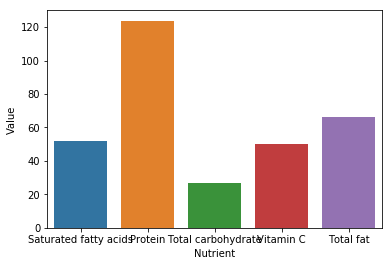

In [28]:
plot_recipe_nutrients(recipes)

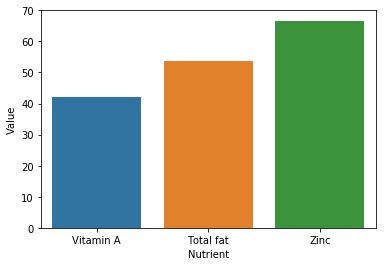

In [29]:
plot_recipe_nutrients(recipe_id2, nutrients)

These plots are however not really easy to interpret and contain a lot of irrelevant informations. We need a better way to both make the visualization better and get a few easily understandable values.

## Evaluating the healthiness of a recipe

There are different ways to measure how healthy some food is and none of them is perfect. It should be intuitive and take into account the main aspects of nutrition. There is for example the nutritional score explained (in french) [here](https://fr.blog.openfoodfacts.org/news/decouvrez-les-notes-nutritionnelles-de-5-couleurs-a-b-c-d-e-pour-10-000-produits-alimentaires-francais-sur-open-food-facts) and [here](https://fr.openfoodfacts.org/score-nutritionnel-experimental-france). A score is calculated for each meal based on the nutrients and then a letter from A (good) to E (bad) is given. The advantage is that it's very easy to understand for a customer who has no knowledge in nutrition.

We would also like to normalize the weight of the recipes : it is unfair to compare recipes which don't have the same weight because the weighlier it is, the more unhealthy they will seem. More of the weight of each recipe is contained in the water, in the carbohydrates, in the proteins, in the lipids, in the fibers, or in the ash (and we have these values). We are here calculating and adding it to the data frame :

In [30]:
temp = nutrition.copy().reset_index()
temp.set_index('recipe_id', inplace=True)

x1 = temp[temp['attribute'] == 'CHOCDF']['value']
x2 = temp[temp['attribute'] == 'FAT']['value']
x3 = temp[temp['attribute'] == 'ASH']['value']
x4 = temp[temp['attribute'] == 'PROCNT']['value']
x5 = temp[temp['attribute'] == 'FIBTG']['value']
x6 = temp[temp['attribute'] == 'WATER']['value']
x6 = temp[temp['attribute'] == 'SUGAR']['value']

s = x1.add(x2, fill_value=0).add(x3, fill_value=0).add(x4, fill_value=0).add(x5, fill_value=0).add(x6, fill_value=0)

s = pd.DataFrame(data={'Value': s})
s['Nutrient'] = 'Weight'
s['Unit'] = 'grams (g)'

s = s.reset_index().set_index(['recipe_id', 'Nutrient'])

df = df.append(s)

Finally, the data frame **df** contains all the informations needed for all the visualizations. It's the final cleaned version of nutrition and we can save it for later uses.

In [31]:
df.to_csv('full_nutrition_cleaned_final.csv', encoding='utf-16')

### The traffic light rating

The traffic light rating system is easy to understand for the customer and we have the data to make it. It looks like the nutritional score explained above and [here](https://en.wikipedia.org/wiki/Traffic_light_rating_system) is a link explaining how it works. For each value of 'Total fat', 'Saturated fatty acids', 'Sugar' and 'Sodium' we get a number between 1 (good, color green) and 3 (bad, color red) and take the sum of these scores.

The file helpers_nutrition.py contains functions to calculate these scores and to plot them easily.

In [32]:
from helpers_nutrition import *

df = pd.read_csv('full_nutrition_cleaned_final.csv', index_col=['recipe_id', 'Nutrient'], encoding='utf-16')

Let's plot the distribution of the traffic light scores over the recipes. The scores are between 4 and 12 and the higher they are, the more unhealthy the food is. For this plot we chose to keep only real meals, i.e. recipes whose weight is more than 100g. We are here taking the list of those recipes ids :

In [33]:
df_sorted = df.sort_index()
df_sorted = df_sorted.loc(axis=0)[:, 'Weight']
df_sorted = df_sorted[df_sorted['Value'] > 100]

recipes = list(set(list(df_sorted.index.get_level_values(0))))

From the recipes of this list, we may wonder what the traffic light score distribution looks like. Let's plot it and see how healthy the recipes are.

In [34]:
green = 0
orange = 0
red = 0

scores_list = []

for recipe in recipes:
    score = traffic_light_score(df, recipe)
    scores_list.append(score)
    
    color = score_to_color(score)
    if color == 'Green':
        green += 1
    if color == 'Orange':
        orange += 1
    if color == 'Red':
        red += 1

In [35]:
%load_ext autoreload
%autoreload 2

Green : 149, Orange : 4263, Red : 7757
The mean score is 9.75.


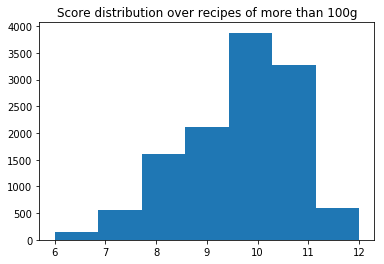

In [36]:
print('Green : {0}, Orange : {1}, Red : {2}'.format(green, orange, red))

plt.hist(scores_list, bins=7);
plt.title('Score distribution over recipes of more than 100g')

print('The mean score is {}.'.format(np.round(np.mean(scores_list), 2)))

Most recipes get a red flag (~63%) and there is a huge predominance of unhealthy food : most of the recipes get a score over 9 on a scale from 4 to 12, the mean being 9.75. Only 1% is green and 35% orange. The following boxplot is more easily interpretable and clearly shows how unhealthy the food is overall.

Text(0.5,1,"Boxplot of the recipes' healthiness distribution")

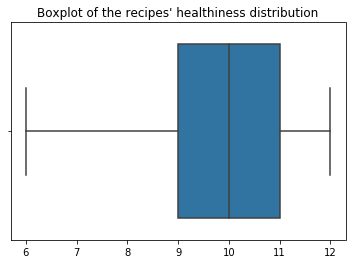

In [45]:
sns.boxplot(scores_list);
plt.title('Boxplot of the recipes\' healthiness distribution')

The function **draw_traffic_light_image** implemented in **helpers_nutrition** can be used to plot the summary of a recipe's main nutrients. It's supposed to be easily interpretable for any user with green-orange-red colors. Here are a few examples of the results we get :

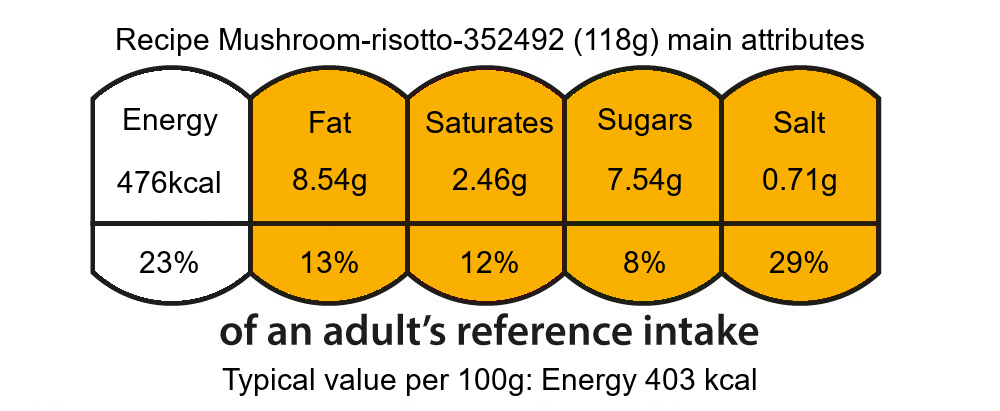

In [37]:
draw_traffic_light_image(df, dvr, recipe_id1)

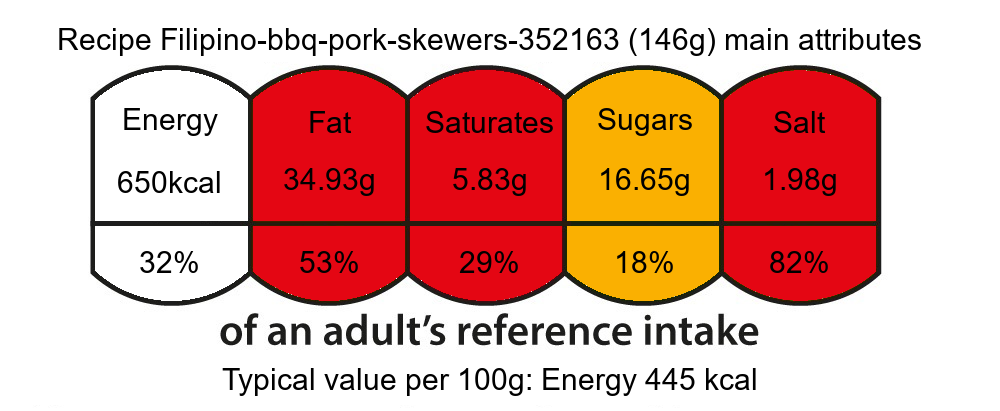

In [38]:
draw_traffic_light_image(df, dvr, recipe_id2)

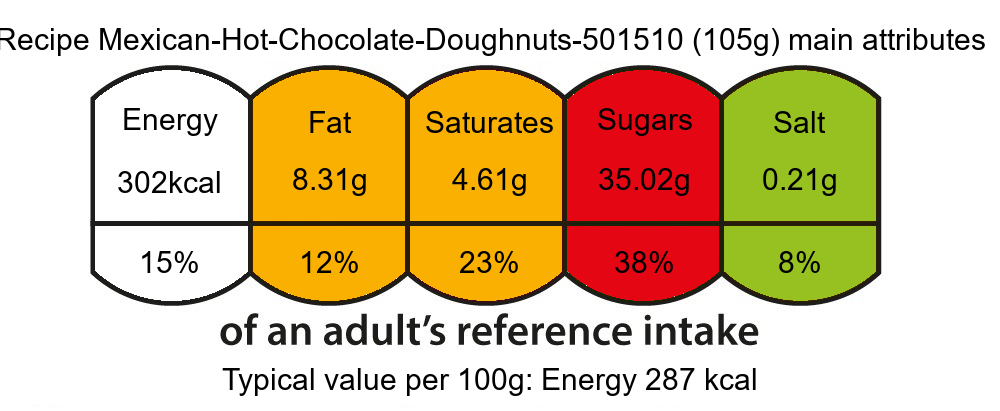

In [39]:
draw_traffic_light_image(df, dvr, recipe_id3)

# Recommender system

In this notebook, we build a recommender system for recipes based on saved recipes by users.
For this, we compute similarities between recipes using the well known cosine similarity applied to vectors of 0 and 1 for each user where we put 1 if the user saved the recipe and 0 otherwise.  
Thanks to this recommender, we then build an interactive recommender, which allows to recommend recipes based on the recipes that the user has already saved. It also allows to the user to select some constraints for his recommendations. For instance, he can chose within nutrition constraints (e.g. the number of kcal he wants in his recipe), time constraints, or even course or type of cuisine.  
### ( ! ) If you want to interact with this recommender, please download the Demo folder at the following URL and run the 'Demo.ipynb': https://drive.google.com/drive/folders/1DAlZxPuP3b5Bfkv_HWRQCKEUow65i5-D?usp=sharing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

For this part, we use data of the form (u, r) pairs where each pair indicate that user u has saved recipe r.

In [592]:
saved_recipes = pd.read_json('saved_recipes.json')
saved_recipes = saved_recipes[['user', 'recipe_id']]
saved_recipes.head(10)

,user,recipe_id
0,SapnaPadte,ROASTED-BEET_-PEAR-_-WALNUT-SALAD-1895162
1,SapnaPadte,Farro-Salad-with-Roasted-Mushrooms-and-Parmesa...
2,SapnaPadte,Braised-Short-Ribs-2019358
3,SapnaPadte,Mushroom-Risotto-1571924
4,SapnaPadte,Crockpot-Chicken-and-Stuffing-1900892
5,SapnaPadte,Swiss-Chard-And-Sweet-Potato-Gratin-1818910
6,SapnaPadte,Glazed-Tofu-with-Bok-Choy-1459225
7,SapnaPadte,Ricotta-and-Oyster-Mushroom-Lasagna-1159281
8,SapnaPadte,Cilantro-Lime-Coconut-Rice-1086839
9,SapnaPadte,Garlic-Roasted-Asparagus-1053963


In [593]:
all_recipes = list(saved_recipes.recipe_id.unique())
all_users = list(saved_recipes.user.unique())
print('We have data from {} users who saved in total {} recipes '.format(len(all_users), len(saved_recipes)) +
      'making an average of {} recipes saved per user '.format(round(len(saved_recipes)/len(all_users), 2)))

We have data from 4046 users who saved in total 109264 recipes making an average of 27.01 recipes saved per user 


For better performance in terms of speed and results, we only keep users who saved at least 10 recipes and recipes which have been saved at least 3 times to reduce the size of the dataset in order to keep only items of interest

In [598]:
recipes_cp = all_recipes.copy()
for r in recipes_cp:
    n_users_who_saved_recipe = len(saved_recipes[saved_recipes.recipe_id == r])
    if(n_users_who_saved_recipe < 3):
        all_recipes.remove(r)
users_cp = all_users.copy()
for u in users_cp:
    n_saved_recipes_for_user = len(saved_recipes[saved_recipes.user == u])
    if(n_saved_recipes_for_user < 20):
        all_users.remove(u)
print('From this, it now remains {} users and {} recipes'.format(len(all_users), len(all_recipes)))

From this, it now remains 3257 users and 6662 recipes


We now filter our data by keeping only users and recipes of interest and save this dataframe to use it later on without having to do again all the computations.

In [2]:
to_drop = []
for i in range(len(saved_recipes)):
    u = saved_recipes.loc[i].user
    r = saved_recipes.loc[i].recipe_id
    if(not u in all_users or not r in all_recipes):
        to_drop.append(i)
        
to_save = saved_recipes.drop(to_drop)
to_save.reset_index()
to_save.to_csv('useful_saved_recipes.csv')

In [596]:
saved_recipes = pd.read_csv('useful_saved_recipes.csv')[['user', 'recipe_id']]
all_recipes = list(saved_recipes.recipe_id.unique())
all_users = list(saved_recipes.user.unique())

Now we transform this data into a new dataframe having recipes as columns and users as index, which will contain 1 or 0 depending on if the user has saved or not the recipe.

In [285]:
saved_recipes_for_users = dict()
for u in all_users:
    saved_recipes_for_users[u] = list(saved_recipes[saved_recipes.user == u].recipe_id)

In [286]:
matrix_data = np.zeros((len(all_users), len(all_recipes)))
# For all users
for i in range(len(all_users)):
    u = all_users[i]
    # For all recipes
    for j in range(len(all_recipes)):
        r = all_recipes[j]
        # If user u has saved recipe r set (u, r) = 1
        if(r in saved_recipes_for_users[u]):
            matrix_data[i, j] = 1   
# put the resulting matrix in a dataframe
saved = pd.DataFrame(matrix_data, index = all_users, columns = all_recipes)

Save the dataframe 

In [288]:
saved.to_csv('saved_matrix.csv')

Now we can make our reommendations based on the saved recipes. 

In [290]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

# reload the data
saved = pd.read_csv('saved_matrix.csv', index_col='Unnamed: 0')

# As a first step we normalize the user vectors to unit vectors.
magnitude = np.sqrt(saved.sum(axis=1)) #np.sqrt(np.square(saved).sum(axis=1)) but 0^2=0 and 1^2=1
saved = saved.divide(magnitude, axis='index')

# remove nan values
saved[np.isnan(saved)] = 0

def calculate_similarity(data_items):
    """
    Compute similarities between recipes
    return a new dataframe with recipes as columns and index 
    and the similarity score between recipes r1 and r2 at their position
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index=data_items.columns, columns=data_items.columns)
    return sim

We first make item-item recommendations

In [291]:
# Build the similarity matrix
sim_matrix = calculate_similarity(saved)

print('recipes most similar to Mushroom-Risotto-1571924: \n')
print(sim_matrix.loc['Mushroom-Risotto-1571924'].nlargest(5))

recipes most similar to Mushroom-Risotto-1571924: 

Mushroom-Risotto-1571924                                   1.000000
Farro-Salad-with-Roasted-Mushrooms-and-Parmesan-1542254    0.339569
POTATO-GNOCCHI-WITH-MUSHROOMS-AND-FETA-1422882             0.289354
Bacon-Cheddar-Scallion-Scones-677696                       0.283927
Greek-Moussaka-2119898                                     0.267662
Name: Mushroom-Risotto-1571924, dtype: float64


Finally we compute user-item recommendation which we will use for our recommendations

In [599]:
user = 'Axel' # my user ID that I created for demo purposes

def recommend_for_user(user):
    
    # Users likes for all items as a sparse vector.
    user_rating_vector = saved.loc[user]
    
    # Get the recipes the user has liked.
    known_user_likes = user_rating_vector[user_rating_vector > 0].index.values

    # Calculate the score.
    score = sim_matrix.dot(user_rating_vector).div(sim_matrix.sum(axis=1))

    # Remove the known likes from the recommendation.
    score = score.drop(known_user_likes)    
    
    return known_user_likes, score

# Print the known saved and the top 10 recommendations.
known_user_likes, score = recommend_for_user(user)
print('Saved items by user {}:'.format(user))
print(known_user_likes)
print()
print('Recommendations for user {}:'.format(user))
print(score.nlargest(10))

Saved items by user Axel:
['Spaghetti-alla-Carbonara-902641' 'Classic-Swiss-Fondue-My-Recipes'
 'Lemon-Madeleines-Martha-Stewart-195085'
 'Tarte-Tatin-An-Easy-Classic-French-Dessert-141...'
 'Cherry-Clafouti-513493' 'Chocolate-mousse_-french-style-357262'
 'French-Baguette-Sandwich-374433' 'Croque-Monsieur-Martha-Stewart-227846'
 'Creme-Fraiche-Chicken-Allrecipes'
 'Delicious-Grilled-Hamburgers-Allrecipes'
 'Chicken_-Spinach-and-Artichoke-Calzones-1019821' 'My-Tiramisu-571297'
 'Greek-Salad-1398313' 'Beef-taco-skillet-348744'
 'paghetti-and-Meatballs-Martha-Stewart'
 'Quick-Barbecue-Chicken-My-Recipes' 'Sweet-Potato-Fries-Martha-Stewart'
 'Homemade-Guacamole-1058667' 'Four-Cheese-Pizza-MyRecipes-245856'
 'Quiche-Lorraine-Ii-Allrecipes' 'French-Crepes-1258186']

Recommendations for user Axel:
Mandu-Recipe-_Korean-Dumplings_-496808                        0.007605
Pan-Seared-Ahi-Tuna-1192074                                   0.006090
Pasta-with-Braised-Broccoli-and-Tomato-Serious-Eats-200

# Interactive recommender

In [441]:
from ipywidgets import widgets
import ipywidgets as widgets

Now, We will make the recommendations based on given constraints chosen by the users. These constraints can be nutrition, time, course or cuisine type constraints. For this we will use two dataframes. The first one contains the recipes which will help us to make recommendations based on cuisine, time, or even ingredients constraints. The last one contains nutrition informations which will also help us to make recommendations based this time on nutrional constraints.

In [532]:
recipes = pd.read_csv('recipes.csv').sample(frac=1, random_state=42)
recipes.head()

,recipe_id,name,totalTime,course,cuisine,ingredients
29401,Spaghetti-alla-Bolognese-815132,Spaghetti alla Bolognese,3600.0,Main Dishes,Italian,"['2 Möhren', '1 Stange Staudensellerie', '1 Zw..."
4143,Chile-con-Queso-495022,Chile con Queso,600.0,Appetizers,Mexican,"['8 oz Velveeta, cut into large cubes', '1/4 c..."
6311,Thai-grilled-steak-salad-308114,Thai Grilled Steak Salad,1800.0,Main Dishes,Thai,"['1 1/2 pounds rib eye steak', '1/4 cup lime j..."
5514,Courgette-And-Lemon-Spaghetti-597814,Courgette And Lemon Spaghetti,1800.0,Main Dishes,Italian,"['200g spaghetti', '3 tbsp light olive oil, pl..."
16366,Curried-Chicken-with-Coconut-Rice-528451,Curried Chicken with Coconut Rice,3000.0,Main Dishes,Indian,"['1 whole chicken (3 1/2 to 4 pounds), cut int..."


In [533]:
nutrition = pd.read_csv('nutrition.csv')
filtered_nutrition = nutrition[['recipe_id', 'attribute', 'description', 'unit_name', 'unit_abbreviation', 'value']]
filtered_nutrition = filtered_nutrition.set_index(['recipe_id', 'attribute'])
filtered_nutrition.head(10)

description unit_name  \
recipe_id              attribute                                              
1-2-3-Jambalaya-514797 FAT_KCAL                               NaN   calorie   
                       NaN                             Sodium, Na      gram   
                       ZN                                Zinc, Zn      gram   
                       PRO_G                              Proline      gram   
                       FAT                      Total lipid (fat)      gram   
                       VITC        Vitamin C, total ascorbic acid      gram   
                       ENERC_KCAL                          Energy   calorie   
                       VITA_IU                      Vitamin A, IU        IU   
                       ILE_G                           Isoleucine      gram   
                       SER_G                               Serine      gram   

                                  unit_abbreviation   value  
recipe_id              attribute                             
1-2-3-Jambalaya-514797 FAT_KCAL                kcal   20.00  
                       NaN                        g    0.09  
                       ZN                         g    0.00  
                       PRO_G                      g    0.38  
                       FAT                        g    1.56  
                       VITC                       g    0.01  
                       ENERC_KCAL              kcal   62.24  
                       VITA_IU                   IU  778.61  
                       ILE_G                      g    0.38  
                       SER_G                      g    0.38

In [534]:
# keep only the kcal column
cal_df = nutrition
cal_df = cal_df[cal_df.attribute == 'ENERC_KCAL'].reset_index()
cal_df = cal_df[['recipe_id', 'value']].sample(frac=1, random_state=42)
cal_df.columns = ['recipe_id', 'kcal']
cal_df.head()

,recipe_id,kcal
96,4-Ingredient-Pizza-Crust-_Paleo_-Low-Carb_-168...,379.65
19052,Bibimbop-MyRecipes-266376,845.64
12930,Fried-Green-Tomato-and-Shrimp-Sliders-605119,157.16
9396,Horseradish-Mashed-Potatoes-Epicurious-203314,191.58
26451,Southwest-Chicken-Tortilla-Bake-1198642,474.04


Now we merge the two dataframes into a unique one to get all the needed data in one dataframe

In [699]:
df_original = pd.merge(recipes, cal_df, how='inner', on='recipe_id')
df_original = df_original[['recipe_id', 'name', 'totalTime', 'course', 'cuisine', 'kcal', 'ingredients']]
df_original['totalTime'] = df_original['totalTime']/60
df_original = df_original[(df_original.recipe_id.isin(all_recipes))]
df_original = df_original.dropna()
df_original = df_original.drop_duplicates(subset='recipe_id').reset_index(drop=True)
df = df_original.copy()
df_original.head(5)

,recipe_id,name,totalTime,course,cuisine,kcal,ingredients
0,Greek-Chicken-Sheet-Pan-Dinner-with-Green-Beans-and-Feta-2153381,Greek Chicken Sheet Pan Dinner with Green Beans and Feta,55.0,Main Dishes,Mediterranean,361.16,"['1 pound baby Dutch yellow potatoes', '1 pound green beans', '1 15-ounce can petite diced tomatoes', '2 pounds chicken breasts', '2 1/2 lemons (1 1/2 juiced, and 1 sliced)', '8 cloves garlic (4 m..."
1,Mango-Lassi-Simply-Recipes-43078,Mango Lassi,20.0,Beverages,Indian,203.79,"['1 cup plain yogurt', '1/2 cup milk', '1 cup chopped mango (peeled and stone removed)', '4 teaspoons sugar, to taste', 'A dash of ground cardamom (optional)']"
2,Healthy-Fettuccine-Alfredo-499280,Healthy Fettuccine Alfredo,30.0,Main Dishes,Italian,343.93,"['1 lb. uncooked fettuccine noodles', '3 small heads cauliflower', '6 cups vegetable broth', '6 cloves garlic, minced', '1 tablespoon butter', '1 teaspoon salt', 'pinch of nutmeg', 'pinch of black..."
3,Mexican-Pasta-Casserole-2230854,Mexican Pasta Casserole,45.0,Main Dishes,Kid-Friendly,558.08,"['1 lb ground beef', '1 (15.25 oz) can corn, drained', '2 c. uncooked spiral pasta', '1 (15.5 oz) jar salsa', '1 (10 3/4 oz) can condensed cream of chicken soup', '1 c. shredded Mexican cheese, di..."
4,Iced-Pumpkin-Cookies-1605604,Iced Pumpkin Cookies,80.0,Desserts,Kid-Friendly,122.02,"['2 1/2 cups all-purpose flour', '1 teaspoon baking powder', '1 teaspoon baking soda', '2 teaspoons ground cinnamon', '1/2 teaspoon ground nutmeg', '1/2 teaspoon ground cloves', '1/2 teaspoon salt..."


In [668]:
daily_value_references = pd.read_csv('daily_value_references.csv', encoding='utf-16')
nutrition2 = pd.read_csv('full_nutrition_cleaned_final.csv', index_col=['recipe_id', 'Nutrient'], encoding='utf-16')

Now we have all what we need to build our interactive recommender which will allow us to select our constraints and propose some recommendations in real time based on theses constraints 

In [802]:
from helpers_nutrition import *

def update_x_range(*args):
    if(x.value > y.value):
        x.value = y.value
    y.observe(update_x_range, 'value')
    
def update_y_range(*args):
    if(y.value < x.value):
        y.value = x.value
    x.observe(update_y_range, 'value')

# Function which filters our data and compute the recommendations based on the selected constraints 
def f(Filter_by_kcal, min_kcal, max_kcal, Filter_by_time, t, User, Course, Cuisine, n_rec):
    
    # take all the data
    df = df_original.copy()
    df['URL'] = 'https://www.yummly.com/#recipe/' + df['recipe_id']
    
    # filter the recipes with respect to our constraints
    if(Filter_by_kcal):
        df = df[df.kcal >= min_kcal]
        df = df[df.kcal <= max_kcal]
    if(Course != 'All'):
        df = df[df.course==Course]
    if(Cuisine != 'All'):
        df = df[df.cuisine==Cuisine]      
    if(Filter_by_time):
        df = df[df.totalTime <= t]
    
    # display the recommendations 
    if(df.empty):
        print('Sorry, no recommendation')
    else:
        columns = ['name', 'kcal', 'totalTime']
        if(Course == 'All'):
            columns.append('course')
        if(Cuisine == 'All'):
            columns.append('cuisine')

        known_user_likes, score = recommend_for_user(User)
        score_df = pd.DataFrame(score).reset_index()
        score_df.columns = ['recipe_id', 'score']
        df = pd.merge(score_df, df, how='inner', on='recipe_id') 
        df = df.sort_values(by = 'score', ascending=False).reset_index(drop=True)
        
        print('Here are some recommendations for user', User, ':')
        print(df[['URL']].head(n_rec))
        display(df[columns].head(n_rec))
        
        n_plots = min(n_rec, 4)
        fig, axes = plt.subplots(nrows=int(np.ceil(n_plots/2)), ncols=2, figsize=(15,6))
        for i in range(n_plots):
            img = draw_traffic_light_image(nutrition2, daily_value_references, df.recipe_id[i], df.name[i])
            if(n_plots==2):
                axes[i].imshow(img)
                axes[i].axis('off')
            else:
                axes[int(i/2), i%2].imshow(img)
                axes[int(i/2), i%2].axis('off')
        plt.show()

Unfortunately, we didn't find a way to interact with our recommender using Github. Hence if you want to interact with it, please download the Demo folder at the following URL and run the 'Demo.ipynb': https://drive.google.com/drive/folders/1DAlZxPuP3b5Bfkv_HWRQCKEUow65i5-D?usp=sharing.

In [3]:
pd.options.display.max_colwidth = 200

x = widgets.IntSlider(min=0, max=2000, step=1, value=0, description='Minimum number of kcal')
y = widgets.IntSlider(min=0, max=2000, step=1, value=2000, description='Maximum number of kcal')

cuisines = sorted(df_original.cuisine.unique())
cuisines.insert(0, 'All')
courses = sorted(df_original.course.unique())
courses.insert(0, 'All')
user_select = all_users[:10];
user_select.insert(0, 'Axel')

t = widgets.IntSlider(min=0, max=120, step=1, value=60, description='Maximum time (min)')
n = widgets.IntSlider(min=2, max=20, step=2, value=4, description='Number of recommendations')

widgets.interact(f, Filter_by_kcal=True, min_kcal=x, max_kcal=y, Filter_by_time=True, t=t, 
                 User=user_select, Cuisine=cuisines, Course=courses, n_rec=n);
update_x_range()
update_y_range()

### To interact with the recommender, please download the Demo folder at the following URL and run the 'Demo.ipynb': https://drive.google.com/drive/folders/1DAlZxPuP3b5Bfkv_HWRQCKEUow65i5-D?usp=sharing.  Otherwise here is what it looks like:

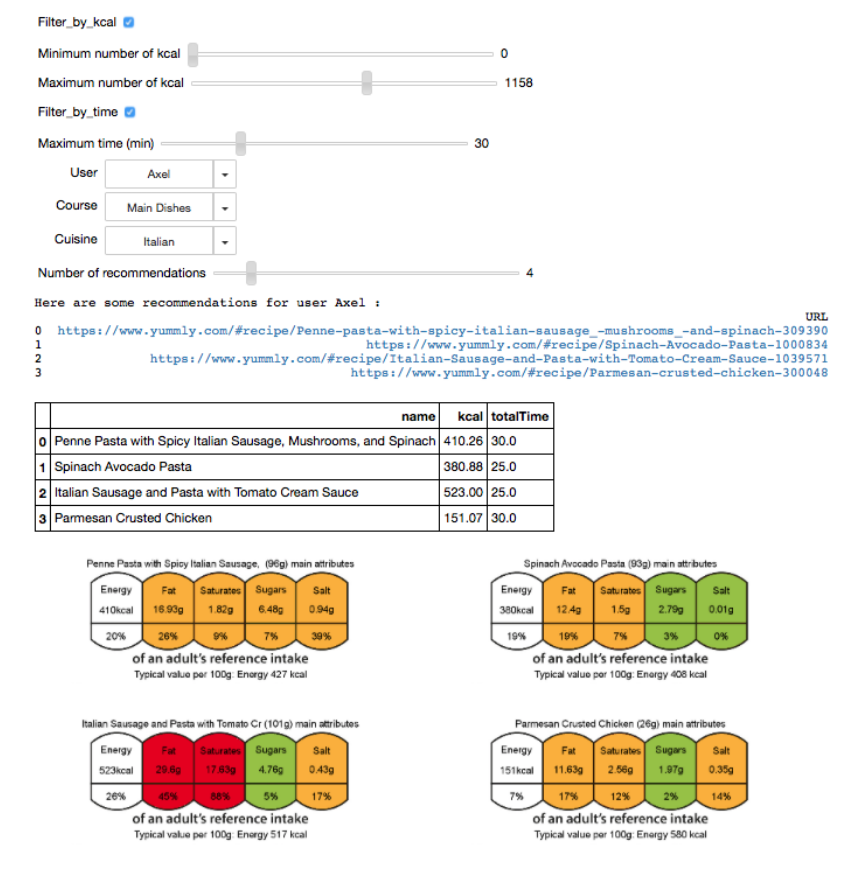

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
img=mpimg.imread('demo.png')
ax.imshow(img)
ax.axis('off')
plt.show()

# Cuisine similarity analysis

For this part we will be using the dataset on recipes, **recipes.csv**. In order to discover cuisine similarities we will need to explore the ingredients of each recipe and try to connect them with different cuisines. The dificulty we will have to face in this part of the project is the format of ingredients given in our dataset. There are a lot of specific stopwords for recipes like measures and the description of ingredients like dry, trim, mixed, so we will need to deal with them approprietly to have the correct calculations per cuisine. 

## Exploring the data



In [8]:
recipes.head(3)

,name,totalTime,course,cuisine,ingredients
recipe_id,,,,,
--Naan_-Boiled-rice-1362073,"- Naan, Boiled rice",4800.0,Main Dishes,Indian,"['100 gms paneer/cottage cheese, grated', '2 m..."
-Spicy-Spaghetti-and-Meatballs-1055356,Spicy Spaghetti and Meatballs,3300.0,Main Dishes,Italian,"['Spicy Tomato Sauce', '1 tbsp olive oil', '1 ..."
1-2-3-Jambalaya-514797,1-2-3 Jambalaya,1800.0,Main Dishes,Cajun & Creole,['1 package (13.5 ounces) Johnsonville® Andoui...


Our data is mainly in string format, except of the totalTime column that has numerical values. Let's check if there are any null values.

In [24]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33872 entries, --Naan_-Boiled-rice-1362073 to Zuppa-di-Pesce-_Italian-Fish-_-Seafood-Stew_-1048784
Data columns (total 5 columns):
name           33872 non-null object
totalTime      30102 non-null float64
course         33550 non-null object
cuisine        29529 non-null object
ingredients    33872 non-null object
dtypes: float64(1), object(4)
memory usage: 2.8+ MB


In [25]:
recipes.isnull().sum()

name              0
totalTime      3770
course          322
cuisine        4343
ingredients       0
dtype: int64

We observe that there are some null values in the totalTime, course and cuisine columns. This could be because some of the recipes don't provide the estimated preparation time, or the cuisine isn't constrained to one type. Let's explore it even further.

In [1003]:
recipes['totalTime'].max()

1440600.0

Here we can observe that the most demanding recipe takes more 10 that days to make. :D We were really interested to discover the most time consuming recipe, and we have also extracted its 'url' from json file, so indeed as mentioned on yummly site https://www.yummly.com/recipe/Honey-Mustard-Slow-Cooker-Chicken-2221106, this recipe will take you two weeks to make. But when reading through directions it is clear that this is a mistake, so we should be carefull when analyzing data in our dataset. 

In [27]:
recipes[recipes['totalTime']==recipes['totalTime'].max()]

,name,totalTime,course,cuisine,ingredients
recipe_id,,,,,
Honey-Mustard-Slow-Cooker-Chicken-2221106,Honey Mustard Slow Cooker Chicken,1440600.0,Main Dishes,NaN,['1 package PERDUE® FRESH CUTS™ Chicken Breast...


On the other hand, we observe some recipes that require only few minutes to make, so this will come in handy when trying to come up with a menu for modern busy people that don't have so much time to cook. 

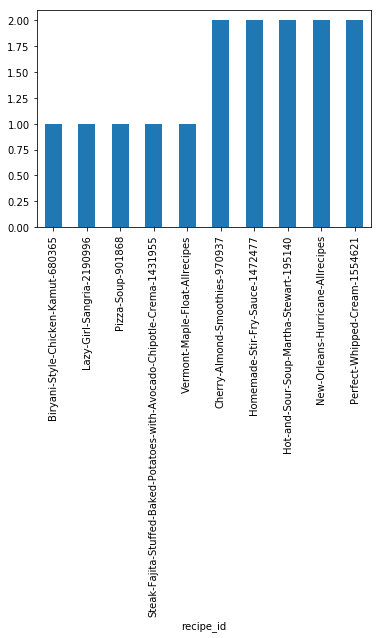

In [10]:
np.divide(recipes['totalTime'],60).nsmallest(10).plot(kind='bar');


Let's explore the cuisine column of our dataset.

In [11]:
train_data = recipes[['cuisine','ingredients']].dropna(axis=0)

cuisine_names = np.sort(train_data['cuisine'].unique())
cuisine_names

array(['American', 'Asian', 'Barbecue', 'Brazilian', 'Cajun & Creole',
       'Chinese', 'Cuban', 'English', 'Filipino', 'French', 'German',
       'Greek', 'Hawaiian', 'Hungarian', 'Indian', 'Irish', 'Italian',
       'Jamaican', 'Japanese', 'Kid-Friendly', 'Korean', 'Mediterranean',
       'Mexican', 'Moroccan', 'Portuguese', 'Russian',
       'Southern & Soul Food', 'Southwestern', 'Spanish', 'Swedish',
       'Thai', 'Turkish', 'Vietnamese'], dtype=object)

In [12]:
train_data['cuisine'].describe()

count        29529
unique          33
top       American
freq         11677
Name: cuisine, dtype: object

Here, we see that we have 33 different cuisine types, and the most frequent one is American with 11677 recipes. Let's see the statistics on the rest of them.

In [13]:
train_data['cuisine'].value_counts(normalize=True,sort=True)[:10]

American        0.395442
Italian         0.161841
Mexican         0.120492
Asian           0.068407
French          0.053337
Indian          0.052051
Kid-Friendly    0.048359
Southwestern    0.024925
Barbecue        0.018524
Thai            0.014630
Name: cuisine, dtype: float64

Here we observe that the given train dataset is higly skewed, with a majority of American, Italian and Mexican recipes. We also observed some types of cuisines that are not national cuisines. We want to remove those values in our training data so that we could perform analysis based on different national cuisines around the world.

In [14]:
train_data = train_data[~train_data['cuisine'].isin(['Barbecue','Kid-Friendly','Southern & Soul Food','Cajun & Creole','Southwestern'])]


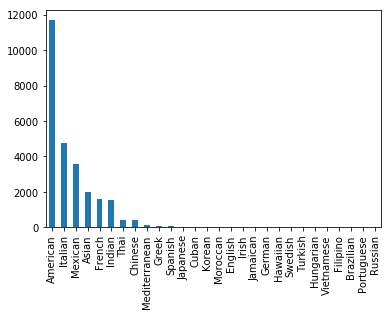

In [15]:
train_data['cuisine'].value_counts().plot(kind='bar');


Let’s now take a closer look at the ingredients. We observe the list of ingredients strings which we will have to clean to get a more suitable shape. 

In [17]:
recipes['ingredients'].head(3)

recipe_id
--Naan_-Boiled-rice-1362073               ['100 gms paneer/cottage cheese, grated', '2 m...
-Spicy-Spaghetti-and-Meatballs-1055356    ['Spicy Tomato Sauce', '1 tbsp olive oil', '1 ...
1-2-3-Jambalaya-514797                    ['1 package (13.5 ounces) Johnsonville® Andoui...
Name: ingredients, dtype: object

Since our ingredients columns is a string representation of list of ingredients, by returning the lenght of that list we get the number of ingredients per recipe. 

In [18]:
import ast
recipes['ingredients'].apply(lambda x: len(ast.literal_eval(x))).describe()

count    33872.000000
mean        11.435286
std          5.338806
min          1.000000
25%          8.000000
50%         11.000000
75%         14.000000
max        123.000000
Name: ingredients, dtype: float64

In [19]:
recipes['course'].unique()

array(['Main Dishes', nan, 'Beverages', 'Condiments and Sauces', 'Soups',
       'Lunch and Snacks', 'Salads', 'Appetizers', 'Lunch', 'Side Dishes',
       'Desserts', 'Breakfast and Brunch', 'Snacks', 'Breads', 'Cocktails',
       'Afternoon Tea'], dtype=object)

In [20]:
recipes['course'].str.contains('Breakfast and Brunch').sum()


885

In [21]:
recipes['course'].value_counts(sort=True)

Main Dishes              16272
Desserts                  3937
Side Dishes               2810
Salads                    2677
Soups                     2241
Appetizers                1645
Condiments and Sauces      908
Breakfast and Brunch       885
Lunch and Snacks           637
Breads                     614
Beverages                  351
Lunch                      295
Snacks                     134
Cocktails                  128
Afternoon Tea               16
Name: course, dtype: int64

Here we can observe that the most common dish in our dataset is the main dish. We also have information about dishes that belong to breakfast category. When creating a menu, we can balance different types of dishes to create a menu that has reasonable distribution of nutritions through out the day.

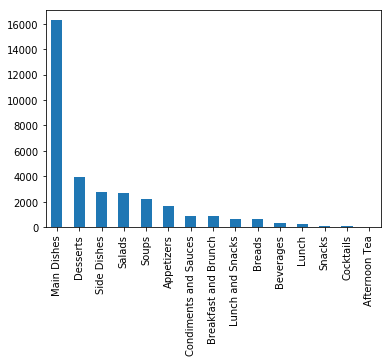

In [22]:
recipes['course'].value_counts().plot(kind='bar')


We can find how many recipes contain certain ingredient. This will help us for the next part of the project, when we want to recommend recipes according to different ingredients they have. 

In [23]:
recipes['ingredients'].str.contains('[Pp]aprika').sum()


1693

We can even take out the recipe that contains a list of recipes, so our user can choose multiple ingredients and expect a meal that would suit that selection.

In [24]:
spice_list = ['salt', 'pepper', 'oregano', 'sage', 'parsley',
                      'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']

In [25]:
import re
spice_df = pd.DataFrame(
           dict((spice, recipes.ingredients.str.contains(spice, re.IGNORECASE))
                                                        for spice in spice_list))
spice_df.head(10)


,cumin,oregano,paprika,parsley,pepper,rosemary,sage,salt,tarragon,thyme
recipe_id,,,,,,,,,,
--Naan_-Boiled-rice-1362073,False,False,False,False,False,False,False,True,False,False
-Spicy-Spaghetti-and-Meatballs-1055356,False,False,False,True,True,False,False,True,False,False
1-2-3-Jambalaya-514797,False,False,False,True,True,False,True,False,False,False
1-Dish-Italian-Meatball-and-Cheese-Pizza-Bake-with-Green-and-Red-Peppers-1266330,False,False,False,False,False,False,False,True,False,False
1-Hour-Vegan-Pot-Pies-747113,False,False,False,False,True,False,False,True,False,False
1-Hour-Vegan-Shepherd_s-Pie-1433748,False,False,False,False,True,False,False,False,False,True
1-Week-of-Green-Smoothie-Prep-Packs-2077993,False,False,False,False,False,False,False,False,False,False
10-Layer-Taco-Salad-1278093,False,False,False,False,False,False,False,False,False,False
10-minute-arrabbiata-sauce-299924,False,False,False,False,True,False,False,False,False,False


In [26]:
selection = spice_df.query('parsley & paprika & tarragon')
selection


,cumin,oregano,paprika,parsley,pepper,rosemary,sage,salt,tarragon,thyme
recipe_id,,,,,,,,,,
Bouillabaisse-Martha-Stewart-193677,True,False,True,True,True,False,False,True,True,False
Bouillabaisse-Martha-Stewart-197529,True,False,True,True,True,False,False,True,True,False
Buttermilk-Fried-Chicken-Simply-Recipes-43147,False,False,True,True,True,False,False,True,True,True
Nicoise-Eggs-628216,True,False,True,True,True,False,False,True,True,False
Smoked-Bluefish-Rillettes-513902,False,False,True,True,False,False,False,True,True,True


We found all the recipes that contained our preferable ingredients.

In [28]:
recipes['name'][selection.index]

recipe_id
Bouillabaisse-Martha-Stewart-193677                          Bouillabaisse
Bouillabaisse-Martha-Stewart-197529                          Bouillabaisse
Buttermilk-Fried-Chicken-Simply-Recipes-43147     Buttermilk Fried Chicken
Nicoise-Eggs-628216                                           Nicoise Eggs
Smoked-Bluefish-Rillettes-513902                 Smoked Bluefish Rillettes
Name: name, dtype: object

## Cleaning data for cuisine similarity analysis 

In the next part of the project, our goal is to discover the similarity between different cuisines based on the ingredients used for the recipes. This part is mainly focused on textual analysis as the ingredients come in shape of list of strings. In order to get a clear view on recipes and ingredients we need to clean the data by removing numbers, and special stopwords used in kitchen, like measure units and the description of ingredients. 

In [29]:
import nltk

In [30]:
display(train_data['ingredients'].head(3))

recipe_id
--Naan_-Boiled-rice-1362073                                                         ['100 gms paneer/cottage cheese, grated', '2 m...
-Spicy-Spaghetti-and-Meatballs-1055356                                              ['Spicy Tomato Sauce', '1 tbsp olive oil', '1 ...
1-Dish-Italian-Meatball-and-Cheese-Pizza-Bake-with-Green-and-Red-Peppers-1266330    ['Cooking Spray', '1-3/4 cups all-purpose flou...
Name: ingredients, dtype: object

In [31]:
from nltk.stem import WordNetLemmatizer
from collections import Counter
from collections import defaultdict
stemmer = WordNetLemmatizer()
import re

stem_original_dic = {}
def clean_recipe(recipe):
    # To lowercase
    recipe = recipe.lower()
    
    def replacing(recipe):
        recipe = recipe.replace('&', '').replace('(', '').replace(')','').replace("*",'').replace('~','')
        recipe = recipe.replace('\'', '').replace('\\', '').replace(',','').replace('{','')
        recipe = recipe.replace('.', '').replace('%', '').replace('/','').replace('!','')
        recipe = recipe.replace('"', '').replace('[','').replace(']','').replace('?','')
        recipe = recipe.replace('-','').replace(';','').replace(':','').replace('}','')
        sep = 'garnishes' 
        recipe = re.sub(sep, '', recipe)
        return recipe

    # Replacing characters
    recipe = replacing(recipe)

    # Remove digits
    def test(recipe):
        return re.sub("\d+", "", recipe)
    recipe = [test(word) for word in recipe.split(' ')]

    # Filter empty words
    recipe = list(filter(None,recipe))

    # Remove stop words
    cachedStopWords = set(nltk.corpus.stopwords.words("english"))
    
    #Stem ingredients and save original ingredient name
    for ingredient in recipe:
        stem_original_dic[stemmer.lemmatize(ingredient)] = ingredient
    recipe = [stemmer.lemmatize(ingredient) for ingredient in recipe]

    #add custom words
    cachedStopWords.update(('cup','tablespoon','pound','ounce',
                            'unpeeled','juice','fresh','chopped','rinsed','teaspoon','teaspoons','large','green',
                           'peeled','halved','thawed','scraped','mixed','whole','medium','softened', 'divided',
                            'loosely', 'packed','drained', 'flaked', 'hot', 'cooked','grated','white','sliced',
                            'g','cut','ground','preferably','pounds','centercut','silver','skin', 'trimmed','finely',
                            'stick', 'unsalted','oz','ounces','freshly','black','½','¼','dry','plus','tsp','tbsp','inch',
                            'red','minced','taste','leaves','powder','seeds','diced','sour','lb','coarse','italian','shredded',
                           'dried','sauce','small','crushed','cup','cups','tablespoon','tablespoons','pound','ounce',
                            'unpeeled','juice','fresh','chopped','rinsed','teaspoon','teaspoons','large','green',
                           'peeled','halved','thawed','scraped','mixed','whole','medium','softened', 'divided',
                            'loosely', 'packed','drained', 'flaked', 'hot', 'cooked','grated','white','sliced',
                            'g','cut','ground','preferably','pounds','centercut','silver','skin', 'trimmed','finely',
                            'stick', 'unsalted','oz','ounces','freshly','black','½','¼','dry','plus','tsp','tbsp','inch',
                            'red','minced','taste','leaves','powder','seeds','diced','sour','lb','coarse','italian','shredded',
                           'dried','sauce','small','crushed','httpwwwgimmesomeovencommarinarasaucerecipe','package',
                           'roughlychopped','jar','homemade','storebought','noboil','may','use','entire','container',
                           'freshlygrated','deveined','thinly','cored','seeded','extravirgin','pitted','almost','do––even',
                           'vegetable','handful','dark','cubed','crumbed','english','crumbled','stem','removed','canned',
                           'extra','virgin','vacuumpacked','ozg','httpwwwgimmesomeovencomredenchiladasauce','undrained',
                            'petite','stewed','rom','san','puree','shell','matchsticked','diagonally','part',
                            'soft','brown','additional','package','breast','bite','sized','cube','low','sodium',
                            'light','hoisin','raw','garnish','boneless','skinless','strip','pinch','serving',
                            'bunch','spring','add','heat','optional','oven','roasted','used','brand','excess','like',
                            'c','taste*','⅓','pressed','press','piece','sundried','needed','goldn','favorite','half',
                            'lean','plain','breadcrumb','yellow','lowsodium','tough','bitesized','room','temperature',
                            'unsweetened','generous','sea','roughly','tb','several','dash','worcestershire',
                            'good','stock','boil','salty','shred','size','$','mild','powder*','¾','precooked','great',
                            'liquid','northern','reserved','chunk','bay','swiss','shape','strongly','recommend','using'
                            ,'“spicy”','xacups','fat','frozen','uncooked','spicy','sweet','lb','two','combination',
                          'flat','erythritol','swanson','lb','rotisserie','swanson','andor','lb','chopping','desired',
                            'leaf','ditto','little','fine','mexican','depending','oz}','reduced','fire','according',
                            'diameter','juiced','summer','snipped','mediumsized','tbls','jumbo','long','old','chunk','box','thin', 'purchased',
                            'kick','quarter','per','med','smoked','greek','fried','ring','blackeyed','regular','added','four','blade',
                            'much','pounded','eastern','ï¿½', 'typically','kick!','would','layering','dairy','pace', 'deepfat','deepfat',
                            'big','can','want','prechopped','pull','bottled','mister','leave', 'nosalt','lbs','rough','fingertip','petit',
                            'spici','combin','link','ear','leav','increas','tast','file','case', 'crack','depend','bowtie','dinosaur',
                           'vegetarian','x'))

    #remove stop words
    recipe = set(recipe)-cachedStopWords  

    return list(recipe)

train_data['ingredients_clean'] = train_data['ingredients'].apply(lambda x: clean_recipe(x))





We define a function that returns the frequencies of ingredients used in a specific cuisine. For faster results we use the Counter() object from nltk package. This function will give us an overview of $n$ most common ingredients used in a cuisine by default, and in case we want to see all the ingredients and its frequencies we can use the parameter $full$.

In [32]:
def most_common_ingredients(cuisine_type, n=10, full=False):
    c = Counter()
    for word in train_data[train_data['cuisine']==cuisine_type]['ingredients_clean']:
        c.update(word)
    if full == True:
        return c.most_common()
    else:
        return c.most_common(n)

In [33]:
most_common_ingredients('Indian')

[('salt', 1287),
 ('oil', 1169),
 ('onion', 1158),
 ('garlic', 1149),
 ('ginger', 1135),
 ('clove', 986),
 ('cumin', 974),
 ('tomato', 852),
 ('turmeric', 843),
 ('coriander', 838)]

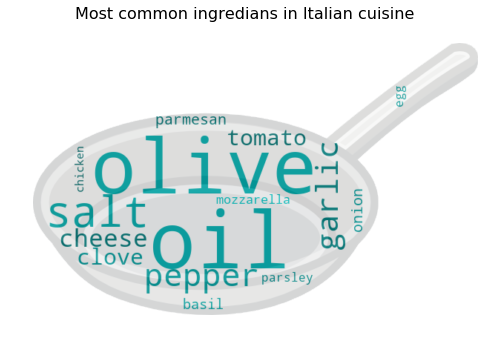

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random

def plot_ingredients_cloud(figure, cuisine):
    pan_mask = np.array(Image.open(os.path.join('data','pan.png')))
    def color_func(word, font_size, position, orientation, random_state=None,
                        **kwargs):
        return "hsl(180, 100%%, %d%%)" % random.randint(20, 40)

    lots = most_common_ingredients(cuisine,full=True)
    wc = WordCloud(background_color="white", color_func=color_func, max_words=15, mask=pan_mask)

    # generate word cloud
    wc.generate_from_frequencies(frequencies=dict(lots))

    # show
    fig.suptitle(str.format("Most common ingredians in {} cuisine",cuisine), fontsize=16)

    plt.imshow(wc, interpolation="bilinear",alpha=1)
    plt.axis("off")
    plt.imshow(pan_mask, cmap=plt.cm.gray, interpolation='bilinear',alpha=0.2)
    plt.axis("off")
    plt.show()

fig = plt.figure(figsize=(12, 5))

plot_ingredients_cloud(fig,'Italian')


Our WordCloud containes most common ingredients for a specific cuisine. It is an interesting overview of our dataset.

In order to find the most similar cuisine, we will take the data on ingredients, and the number of their occurencies in each cuisince, and we will use this as a vector for calculating cosine similarity. 

In [64]:
import math
def cosine_sim(a, b):
    mutual = set(a).intersection(set(b))
    a_serie= pd.Series(list(set(a).intersection(mutual)))
    b_serie= pd.Series(list(set(b).intersection(mutual)))
    return 1 - cosine(a_serie, b_serie)

def cosine_distance(ingredient_freq1,ingredient_freq2):
        sumxx, sumxy, sumyy = 0, 0, 0
        commonIngredient = False
        for key in ingredient_freq1:
            if key in ingredient_freq2:
                x = ingredient_freq1[key]
                y = ingredient_freq2[key]
                sumxx += x*x
                sumyy += y*y
                sumxy += x*y
                commonIngredient = True
        if commonIngredient: return sumxy/math.sqrt(sumxx*sumyy)
        else: return 0

def cuisine_similarity(cusine_a, cuisine_b):
    d1 = dict(most_common_ingredients(cusine_a,full=True))
    d2 = dict(most_common_ingredients(cuisine_b,full=True))
    return cosine_distance(d1,d2)


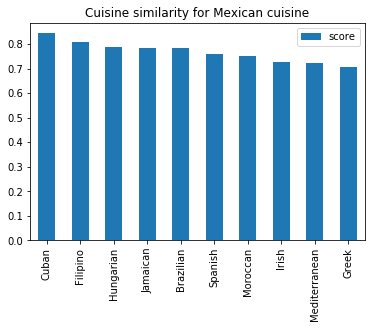

In [103]:
def cuisine_similarity_scores(cuisine_to_compare, for_plot = True):
    similarity_scores = {}
    cuisines = list(train_data['cuisine'].unique())
    if for_plot:
        cuisines.remove(cuisine_to_compare) 
    for cuisine in cuisines:
        similarity_scores.update({cuisine:cuisine_similarity(cuisine_to_compare,cuisine)})
    return similarity_scores

def plot_cuisine_similarities(cuisine):
    
    dataframe = pd.DataFrame.from_dict(cuisine_similarity_scores(cuisine), orient='index')
    dataframe.columns = ['score']
    dataframe.nlargest(10,'score').plot(kind='bar',title = str.format('Cuisine similarity for {} cuisine',cuisine))
    plt.show()

plot_cuisine_similarities('Mexican')

These are the 10 closest cuisines to Mexican. In fact, we could agree that we would expect a similar plot, so the cosine similarity gives a nice interpretation of our data on recipes and cuisines. Now, we could use these scores to map these similarities onto a world map. For this, we will use folium maps, and convert names of cuisines to names of the countries. There are some cuisine types that belong to a region, like Asian and Mediterranean, so for better visualization we will asign this type of cuisine to countries belonging to that region. 

In [82]:
cuisine2region = {
    'American': 'United States of America', 
    'Italian':'Italy',
    'Greek': 'Greece',
    'Mexican': 'Mexico',
    'Thai': 'Thailand',
    'Chinese': 'China',
    'Indian': 'India',
    'English': 'United Kingdom',
    'Korean': 'South Korea',
    'French': 'France',
    'Vietnamese': 'Vietnam',
    'Hawaiian': 'Hawaii',
    'Brazilian': 'Brazil',
    'Filipino': 'Philippines',
    'Hungarian': 'Hungary',
    'Japanese': 'Japan',
    'Turkish': 'Turkey',
    'Spanish': 'Spain',
    'Russian': 'Russia',
    'Irish': 'Ireland',
    'Swedish': 'Sweden',
    'Moroccan': 'Morocco',
    'Cuban': 'Cuba',
    'Jamaican': 'Jamaica',
    'German': 'Germany',
    'Portuguese': 'Portugal',

}
region_cuisine_countries = {'Asian':['Kyrgyzstan','Kazakhstan','Tajikistan','Turkmenistan','Afghanistan','Uzbekistan','Mongolia'],
                        'Mediterranean':['Monaco', 'Malta','Slovenia','Croatia','Bosnia and Herzegovina','Montenegro',
                            'Albania', 'Syria','Cyprus', 'Lebanon', 'Egypt', 'Libya', 'Tunisia','Algeria']}


In [85]:
def similarities_for_map(cuisine):
    similarities = cuisine_similarity_scores(cuisine, for_plot=False)
    pd_similarities = pd.DataFrame.from_dict(similarities, orient='index', dtype=None)
    pd_similarities = pd_similarities.reset_index()
    pd_similarities.columns=['cuisine type', 'score']
    pd_similarities['cuisine type'].update(pd_similarities['cuisine type'].map(cuisine2region))

    for key in region_cuisine_countries.keys():
        score = pd_similarities.loc[pd_similarities['cuisine type'] == key, 'score'].iloc[0]
        for country in region_cuisine_countries[key]:
            pd_similarities = pd_similarities.append(pd.DataFrame([[country, score]], columns=['cuisine type','score']))
    return pd_similarities



In [75]:
world_topo_path = 'data/world-countries.json'
world_topo_json = json.load(open(world_topo_path))

In [76]:
import folium

In [104]:
df_cuisine_similarity = similarities_for_map('Mexican')
df_cuisine_similarity.head()

,cuisine type,score
0,India,0.691228
1,Italy,0.695419
2,Mexico,1.000000
3,Asian,0.632681
4,Thailand,0.609829


In [105]:
def style_function(feature):
    country = df_cuisine_similarity[df_cuisine_similarity['cuisine type']==feature['properties']['name']]['cuisine type'].tolist() 
    if len(country) == 0:
        return {
            'fillOpacity': 0.5,
            'weight': 0,
            'fillColor': '#faebd7'

        }
    else:
        return {
            'fillOpacity': 0,
            'weight': 0,
            'fillColor': '#white'
        
        }

In [46]:
def getJenksBreaks(dataList, numClass):
    dataList.sort()
    mat1 = []
    for i in range(0, len(dataList) + 1):
        temp = []
        for j in range(0, numClass + 1):
            temp.append(0)
        mat1.append(temp)
    mat2 = []
    for i in range(0, len(dataList) + 1):
        temp = []
        for j in range(0, numClass + 1):
            temp.append(0)
        mat2.append(temp)
    for i in range(1, numClass + 1):
        mat1[1][i] = 1
        mat2[1][i] = 0
        for j in range(2, len(dataList) + 1):
            mat2[j][i] = float('inf')
    v = 0.0
    for l in range(2, len(dataList) + 1):
        s1 = 0.0
        s2 = 0.0
        w = 0.0
        for m in range(1, l + 1):
            i3 = l - m + 1
            val = float(dataList[i3 - 1])
            s2 += val * val
            s1 += val
            w += 1
            v = s2 - s1 * s1 / w
            i4 = i3 - 1
            if i4 != 0:
                for j in range(2, numClass + 1):
                    if mat2[l][j] >= v + mat2[i4][j - 1]:
                        mat1[l][j] = i3
                        mat2[l][j] = v + mat2[i4][j - 1]
        mat1[l][1] = 1
        mat2[l][1] = v
    k = len(dataList)
    kclass = []
    for i in range(0, numClass + 1):
        kclass.append(0)
    kclass[numClass] = float(dataList[len(dataList) - 1])
    countNum = numClass
    while countNum >= 2:  # print "rank = " + str(mat1[k][countNum])
        id = int(mat1[k][countNum] - 2)

    # print "val = " + str(dataList[id])

        kclass[countNum - 1] = dataList[id]
        k = int(mat1[k][countNum] - 1)
        countNum -= 1
    return kclass

In [212]:
threshold_scale=getJenksBreaks(list(df_cuisine_similarity['score']),5)
m_world = folium.Map([50,0], tiles='Stamen Terrain', zoom_start=2)
m_world.choropleth(geo_data=world_topo_json,topojson='objects.countries1',data=df_cuisine_similarity,
                    columns=['cuisine type', 'score'],
                    key_on='properties.name',
                    fill_color='YlGn', fill_opacity=0.7, line_opacity=0.5,
                    threshold_scale = threshold_scale,
                    legend_name='Cuisine similarity map for Mexican cuisine'

)
                   
folium.TopoJson(
    open(world_topo_path),
    'objects.countries1',
    style_function=style_function,
).add_to(m_world)
#.add_to(m_europe)


m_world

There we have an overview of the similarities in another form, geographical location. We can see that in fact, the neighbouring countris share the similar taste for food, and the countris more far away don't have a high score in cuisine similarity. 

## Food2Vec - ingredient embeddings

For the next goal of our assignment, we want to explore how different ingredients interact with eachother, and do they form a strong connections based on cuisine in which they are more commonly used. For this, we will use word2vec algorithm, to calculate ingredient vectors and use these vectors to discover the similarity between different ingredients. It would be interesting to see whether this would allow us to see clusters of ingredients based on cuisines.

In [122]:
from gensim.models import word2vec
from sklearn.manifold import TSNE


In [107]:
count_ingredients = Counter()
for word in train_data.dropna(axis=0)['ingredients_clean']:
        count_ingredients.update(word)

count_cuisines = Counter()
for word in [train_data.dropna(axis=0)['cuisine']]:
        count_cuisines.update(word)


In [115]:
count_ingredients.most_common(10)


[('salt', 17732),
 ('pepper', 15127),
 ('oil', 14315),
 ('garlic', 11624),
 ('onion', 11575),
 ('clove', 9491),
 ('olive', 9389),
 ('tomato', 7250),
 ('cheese', 7151),
 ('sugar', 6932)]

In [114]:
count_cuisines.most_common(10)


[('American', 11677),
 ('Italian', 4779),
 ('Mexican', 3558),
 ('Asian', 2020),
 ('French', 1575),
 ('Indian', 1537),
 ('Thai', 432),
 ('Chinese', 392),
 ('Mediterranean', 134),
 ('Greek', 93)]

In [39]:
import ast
train_data['num-ingredients']=''
train_data['num-ingredients'] = train_data['ingredients'].apply(lambda x:len(ast.literal_eval(x)))

In [40]:
df = train_data.groupby('cuisine')['num-ingredients'].agg(['mean','std']).reset_index()


In order to explore the ingredients of different cuisines, we need to make sure that the recipes in each cuisine are similar in terms of ingredient number, because if not, it would direct our results to wrong conclusions based on cuisine that has in average more ingredients than others. 

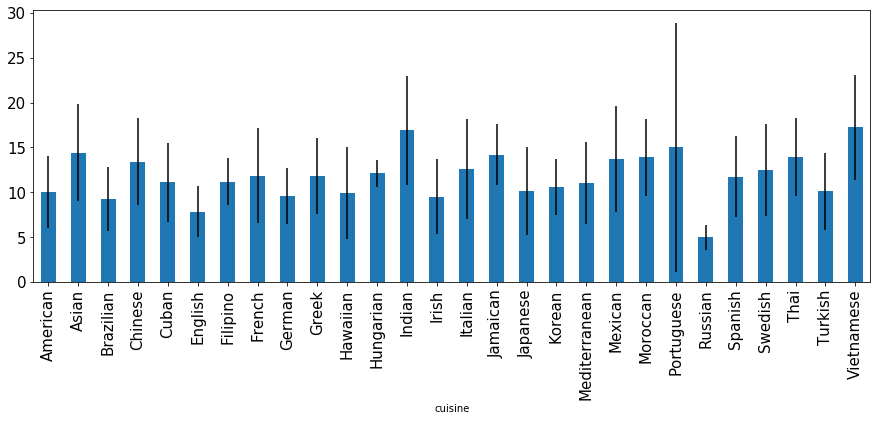

In [41]:
df.plot(figsize=(15,5),legend=False,kind="bar",rot=90,fontsize=15,x='cuisine',yerr='std');


For the paramters of our word2vec algorithm used with food ingredients, we set the context to be the average size of recipes in number of ingredients, and the number of features should take around 50% of the corpus lenght. This makes it 12 for the context and 1500 for the features. By testing this algorithm with different values, it shows that these provide good overall results. Pasta is similar with spaghetti, pork with beef and so on... 

In [245]:
# Set values for NN parameters
num_features = 1500                        
min_word_count = 5                        
num_workers = 40       
context = 12                                                                                                             
downsampling = 1e-3   
                     

# Initialize and train the model 
model = word2vec.Word2Vec(train_data['ingredients_clean'], workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [256]:
model.most_similar('pasta', topn=10)


[('spaghetti', 0.9069350957870483),
 ('pecorino', 0.8577872514724731),
 ('reggiano', 0.8482255935668945),
 ('ricotta', 0.8361855745315552),
 ('fettuccine', 0.8291971683502197),
 ('parmigianoreggiano', 0.8169500827789307),
 ('gnocchi', 0.8169223070144653),
 ('lasagna', 0.8138928413391113),
 ('curlyedged', 0.8138022422790527),
 ('meatball', 0.8063309192657471)]

In [154]:
model.similarity('cheese','pasta')


0.29308503120968471

In [253]:
x = 'pasta'
b = 'pork'
a = 'bacon'
predicted = model.most_similar([x, b], [a])[0][0]
print("{} is to {} as {} is to {} ".format(a, b, predicted, x ))

bacon is to pork as spaghetti is to pasta 


In [248]:
corpus = sorted(model.wv.vocab.keys()) 
emb_tuple = tuple([model[v] for v in corpus])
X = np.vstack(emb_tuple)


We use TSNE for dimension reduction in order to better visualize our ingredient vectors. 

In [249]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [157]:
X_tsne.shape

(3498, 2)

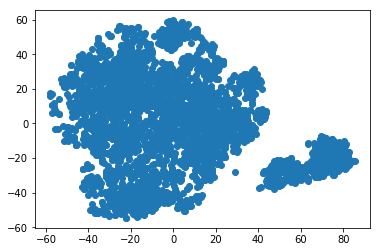

In [257]:
plt.pyplot.scatter(X_tsne[:, 0], X_tsne[:, 1])


In [161]:
cuisine2color = {
    'American': sns.xkcd_rgb["peach"],
    'Asian': sns.xkcd_rgb["powder blue"],
    'Italian': sns.xkcd_rgb["light pink"],
    'Greek': sns.xkcd_rgb["chocolate"],
    'Mediterranean': sns.xkcd_rgb["orange"],
    'Mexican': sns.xkcd_rgb["magenta"],
    'Thai': sns.xkcd_rgb["purple"],
    'Chinese': sns.xkcd_rgb["blue"],
    'Indian': sns.xkcd_rgb["deep blue"],
    'English': sns.xkcd_rgb["sky blue"],
    'Korean': sns.xkcd_rgb["olive"],
    'French': sns.xkcd_rgb["seafoam green"],
    'Vietnamese': sns.xkcd_rgb["tan"],
    'Hawaiian': sns.xkcd_rgb["mauve"],
    'Brazilian': sns.xkcd_rgb["hot pink"],
    'Filipino': sns.xkcd_rgb["pale green"],
    'Hungarian': sns.xkcd_rgb["indigo"],
    'Japanese': sns.xkcd_rgb["lavender"],
    'Turkish': sns.xkcd_rgb["eggplant"],
    'Spanish': sns.xkcd_rgb["brick"],
    'Russian': sns.xkcd_rgb["forest green"],
    'Irish': sns.xkcd_rgb["dark turquoise"],
    'Swedish': sns.xkcd_rgb["terracotta"],
    'Moroccan': sns.xkcd_rgb["mustard yellow"],
    'Cuban': sns.xkcd_rgb["raspberry"],
    'Jamaican': sns.xkcd_rgb["dark peach"],
    'German': sns.xkcd_rgb["bright yellow"],
    'Portuguese': sns.xkcd_rgb["earth"],

}

In [162]:
def ingredients_by_cuisine(cuisine_type):
    c = Counter()
    for word in train_data[train_data['cuisine']==cuisine_type]['ingredients_clean']:
        c.update(word)
    return c

The origin cuisine should give us information about which cuisine is the main cuisine for specific ingredient. In order to calculate this, we look for the maximum proportion of occurencies of that ingredient through different cuisines compared to total number of occurencies in our corpus that was created based on all recipes.  

In [163]:
def origin_cuisine(ingredient):
    record = 0
    mother_cuisine = None
    for cuisine in train_data['cuisine'].unique():
        if ingredients_by_cuisine(cuisine)[ingredient]/count_ingredients[ingredient]>record:
            record = ingredients_by_cuisine(cuisine)[ingredient]/count_ingredients[ingredient]
            mother_cuisine = cuisine
    return mother_cuisine

In [165]:
color_vector = list()
label_vector = list()
for ingredient in corpus:
    cuisine = origin_cuisine(ingredient)
    color_vector.append(cuisine2color[cuisine])
    label_vector.append(cuisine)

In [166]:
import plotly

In [167]:
from collections import defaultdict
keys = label_vector
values = list(X_tsne)
names = corpus
points_names = list(zip(values, names))
dic={}
for x,y in zip(points_names,keys):
    dic.setdefault(y,[]).append(x)

In [251]:
from operator import itemgetter
point_cuisine = zip(X_tsne, label_vector)
traces = []
group_points = []
n = len(dic.keys())
for key in dic.keys():
    group_points = list(map(itemgetter(0), dic[key])) 
    trace = go.Scatter(
        x = np.asarray(group_points)[:, 0],
        y = np.asarray(group_points)[:, 1],
        mode = 'markers',
        marker = dict(
            color = cuisine2color[key],
            size = 8,
            opacity = 0.6,
            #line = dict(width = 1)
        ),
        text = list(map(itemgetter(1), dic[key])),
        hoverinfo = 'text',
        name = key
)
    
    traces.append(trace)


layout = go.Layout(
    xaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        autotick=True,
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        autotick=True,
        ticks='',
        showticklabels=False
    )
)
import plotly.offline as offline

fig = go.Figure(data=traces, layout=layout)

plotter = offline.plot
py.iplot(fig, filename='smt' + '.html') 
#py.iplot(traces, filename='basic-scatter')




In the end, we have observed interesting clusters of ingredients thanks to our word2vec algorithm and dimension reduction. This might be a final touch for this assignment but, a wide range of possibilities can be implemented based on previous work. Can we calculate if a specific cuisine is a mixture of other world cuisines? What would be created when mixing recipes from different cuisines? Can we find substitute ingredients based on this map? It is interestin to see just how many question it could be derived from just one dataset, which is why we should aim to always explore and stay curious. 

# Conclusion

Finally, the recommendation system that we developed is giving reasonable suggestions taking into account the healthiness of the food. The users can still ignore that last part, but we hope that seeing these colored labels for nutrients will encourage them to make the right choice. As most of the recipes are pretty unhealthy, it's hard to find the right balance between recipes the user likes and healthy ones.

With regard to a possible continuation of the work done, the very first step would be to make the interactivity easier, having a website dedicated to that instead of using a notebook. Also, the recommendation system could be improved using several techniques, among other things by combining several types of recommendation systems. Ultimately, the idea would be that the data of each user is saved in real time, including other aspects than just the recipes they liked, and recommend full menus considering the life-style of the user. Another enhancement much harder to implement would consist in automatically adjust and modify the recipes so they keep tasting and looking the same but being more healthy.